In [38]:
import pandas as pd
import numpy as np
from collections import OrderedDict

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

# Формирование абстрактных настроек

Различные классы и объекты которые имеют свойсва всех моделей, которые предполагается строить

## Формируем модель

In [39]:
class ResultNet(nn.Module):

    def __init__(self, neur_counts):
        super(ResultNet, self).__init__()
        # предполагаяется что выходной нейрон
        # всего один и пользователю не надо
        # его объявлять
        neur_counts = neur_counts.copy() + [1]
        
        # динамическое
        # добавление слоев
        layers = OrderedDict()
        for i in range(len(neur_counts) - 1):
            layers[str(i)] = (
                nn.Linear(
                    neur_counts[i],
                    neur_counts[i+1]
                )
            )
            # чтобы каждое обучение совпадало
            # надо, чтобы модели начинали обучение из
            # одной и той же точки - пусть это будут нули
            layers[str(i)].weight = \
            nn.Parameter(
                torch.rand(
                    layers[str(i)].weight.size()
                )
            )
            
            layers[str(i)].bias = \
            nn.Parameter(
                torch.rand(
                    layers[str(i)].bias.size()
                )
            )
            
            
        self.layers = nn.Sequential(layers)
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
            
        x = torch.sigmoid(self.layers[-1](x))
        return x

## Набор данных

In [40]:
class My_data_set(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return [self.X[idx,:], self.Y[idx, :]]

## Функция потерь

Создание функции потерь в torch
https://neptune.ai/blog/pytorch-loss-functions. Для задач бинарной классификации рекомендуют использовать CrossEntropy функцию потерь

In [41]:
loss_fn = nn.BCELoss()

## Обучение модели

Базовый обучающий алгоритм с возвращением данных о обучении по эпохам

In [42]:
def train(
    model, optimizer, loss_fn, train_loader, epochs=20
):
    fun_arr = []
    
    for epoch in range(epochs):

        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
        
        # для отслеживания процесса
        # обучения буду сохранять текущее
        # значение целевой функии
        fun_arr.append(loss_fn(
            net(train_loader.dataset.X),
            train_loader.dataset.Y
        ).item())
    
    return fun_arr

Обучающий алгоритм с постепенным понижением learning rate

In [68]:
def get_loss_value(model, train_loader):
    return loss_fn(
                model(train_loader.dataset.X),
                train_loader.dataset.Y
            ).item()


def train_better(
    model, optimizer, loss_fn, train_loader, epochs=20
):
    fun_arr = []
    fun_arr.append(get_loss_value(model, train_loader))
    
    for epoch in range(epochs):

        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
        
        # для отслеживания процесса
        # обучения буду сохранять текущее
        # значение целевой функии
        fun_arr.append(get_loss_value(model, train_loader))
        
        # если предыдущий шаг привел к понижению целевой
        # функции то надо немного понизить learning rate
        if fun_arr[-2] > fun_arr[-1]:
            for g in optimizer.param_groups:
                g['lr'] = g['lr']/1.1

    
    return fun_arr

Нанесение "кривой обучения" опираясь на массив получаемый из 
train

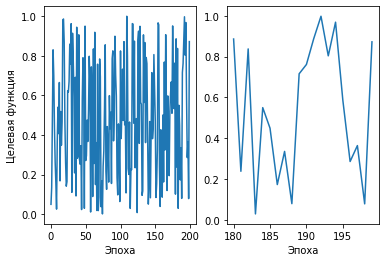

In [69]:
def plot_learning_curve(
    lc_data, start_show = 0, last_spes_show = 20
):
    # inputs:
    # lc_data - собранная итнформация о обучении модели
    # start_show - та эпоха с которой следует начинать обучать
    # last_spes_show - та эпоха c конца с которой следует
    #                  начать отображение в правое окно
    
    plt.subplot(121)
    X_range = \
    range(
        start_show, 
        len(lc_data)
    )

    plt.plot(
        X_range,
        lc_data[list(X_range)]
    )
    plt.xlabel("Эпоха")
    plt.ylabel("Целевая функция")
    
    
    plt.subplot(122)
    X_range = \
        range(
            len(lc_data)-last_spes_show, 
            len(lc_data)
        )
    plt.plot(
        X_range, 
        lc_data[list(X_range)]
    )
    plt.xlabel("Эпоха")


plot_learning_curve(np.random.rand(200))

# Загрузка и подговтовка данных

In [70]:
data = pd.read_csv(
    "/home/dranik/KFA/university/proc_2.csv", 
    index_col = 0
)

X = data.drop('Y',axis = 1)
Y = np.array(data[['Y']])

Нужно провести One Hot Encoding

In [71]:
X = np.concatenate([
    OneHotEncoder(sparse = False).\
    fit_transform(X.loc[:,X.dtypes == "O"]),
    X.loc[:,X.dtypes != "O"].to_numpy()
], axis = 1)

Разбивка на Train/Test

In [72]:
X_train, X_test, y_train, y_test = \
    train_test_split(
        X,Y, random_state = 0, stratify = Y
)

## Создание набора данных и загрузчика данных

In [73]:
train_data = My_data_set(
    torch.tensor(X_train.astype('float32')), 
    torch.tensor(y_train.astype('float32'))
)

In [74]:
train_data_loader =\
torch.utils.data.DataLoader(
    train_data, batch_size=10000
)

# Различные варианты модели

## Модель с одним скрытым слоем

In [81]:
torch.manual_seed(0)

for i in range(12, 13):
    net = ResultNet([X.shape[1], i])
    
    optimizer = optim.Adam(
        net.parameters(), weight_decay = 0.5,
        # lr=0.01, вариант 1 - после того как 100
        # 100 эпох стало мало решил начинать быстрее
        lr = 0.1
    )
    
    
#    print(net.layers[0].bias)
    # обучение======================================
    #lc = train(
    lc = train_better(
        net, optimizer, loss_fn, 
        train_data_loader, epochs = 500
    )
#    print(net.layers[0].bias)
    # обучение======================================
    
    # снятие метрик ================================
    probs_hat = net(
        torch.tensor(X_test.astype('float32'))
    ).detach().numpy()
    
    auc = roc_auc_score(y_test, probs_hat)
    # снятие метрик ================================
    
    # сохранение =================================== 
    fig = plt.figure(figsize = [10,7])
    fig.suptitle(
        str(i) + 
        " нейронов в скрытом слое (AUC = " + \
        str(np.round(auc,3)) + ')')
    plot_learning_curve(np.array(lc), 20, 50)
    fig.savefig(
        "fiting_results/12 testing/" + str(i) +
        " neurons.png"
    )
    plt.close()
    # сохранение ====================================
    
    print(str(i) + " " + str(auc))

12 0.5532913271528236


In [37]:
optimizer = optim.Adam(
    net.parameters(), lr=0.01, weight_decay = 0.5
)
optimizer.defaults

{'lr': 0.01,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'weight_decay': 0.5,
 'amsgrad': False,
 'maximize': False}